In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams["font.size"] = 14

import utils
import importlib
importlib.reload(utils)

import os
import sys
import subprocess

In [2]:
train, test, info, index = utils.ReadData("debug3")

In [3]:
val = test.values
train_for_val = train

In [4]:
log_train_for_val = np.log1p(np.nan_to_num(train_for_val))

In [5]:
# restore indices of weekly seasonal, many zeros
weekly_indices = np.load("../data/google_wtts/weekly_index_for_score.npy")
weekly_indices = np.argwhere(np.isin(index.values.reshape(-1), weekly_indices))

zeros_indices = np.load("../data/google_wtts/zeros_index_for_score.npy")
zeros_indices = np.argwhere(np.isin(index.values.reshape(-1), zeros_indices))

# model

In [6]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [27]:
def plot_train_and_val(i, y_val, title, lags=100):
    x_train = np.arange(lags)
    x_val = np.arange(lags, lags + 60)
    
    y_train = log_train_for_val[i][-lags:]
    
    y_train = y_train[-lags:]
#     y_val = correction(y_val)
    
    plt.vlines(lags, ymin=min(y_val), ymax=max(y_val), linestyles='--')
    plt.plot(np.concatenate((x_train, x_val)),
             np.concatenate((log_train_for_val[i][-lags:], np.log1p(val[i]))),
             label='validation')
    plt.plot(x_train, y_train, label='train')
    plt.plot(x_val, y_val, label='prediction')
    plt.xlabel('days')
    plt.ylabel('log')
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
i = 90
fit1 = ExponentialSmoothing(log_train_for_val[i, -120:], seasonal_periods=7, trend='add', damped=True, seasonal='add').fit()
y_hat_hw = fit1.forecast(60)

In [ ]:
fit1.params

In [22]:
plot_train_and_val(i, y_hat_hw)

NameError: name 'y_hat_hw' is not defined

# Scale

In [17]:
def HoltWinters_for_row(i, winters=False, n_lags=120, trend_damped=False):
    if winters:
        fit = ExponentialSmoothing(log_train_for_val[i, -n_lags:], seasonal_periods=7, 
                                   trend='add', damped=trend_damped, seasonal='add').fit(#use_basinhopping=True
                                                                                        )
        y_hat = fit.forecast(60)
    else:
        fit = Holt(log_train_for_val[i, -n_lags:]).fit(smoothing_level = 0.3,
                                          smoothing_slope = 0.1)
        y_hat = fit.forecast(steps=60)

    return y_hat

In [ ]:
i = 43
preds = HoltWinters_for_row(i, winters=True)

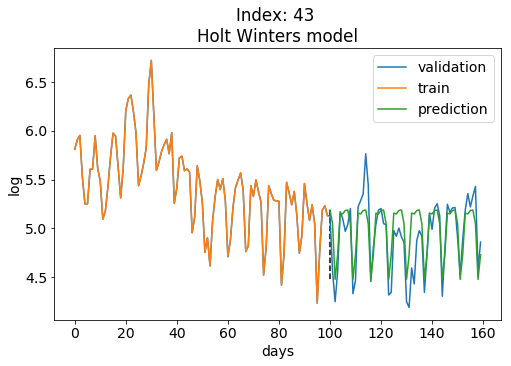

In [28]:
plot_train_and_val(i, preds, 'Index: %i \nHolt Winters model' % i)

In [69]:
from joblib import Parallel, delayed

In [79]:
%%time
predictions333 = Parallel(n_jobs=24, max_nbytes=None)(
    delayed(HoltWinters_for_row)(k, winters=True, trend_damped=False) 
    for k in range(72)
)

CPU times: user 124 ms, sys: 428 ms, total: 552 ms
Wall time: 14.5 s


In [131]:
%%time
predictions = Parallel(n_jobs=24, max_nbytes=None)(
    delayed(HoltWinters_for_row)(k, winters=True, trend_damped=False) 
    for k in range(2000)
)

CPU times: user 11.7 s, sys: 4.22 s, total: 16 s
Wall time: 3h 1min 49s


In [132]:
print('end')
predictions = utils.from_log_and_correction(np.array(predictions))

end


In [85]:
utils.SaveModel("holt_winters",
                predictions, test,
                "120 hours", "no transformation",
                index.values.reshape(-1))

In [87]:
scores = utils.SMAPE_score(test, predictions)

SMAPE:  53.016304


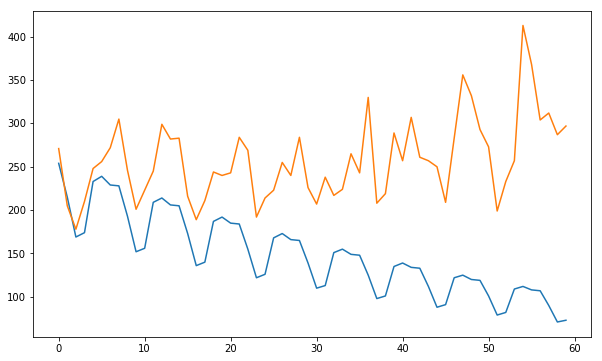

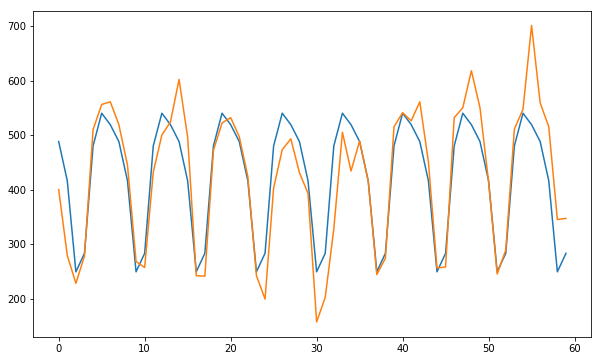

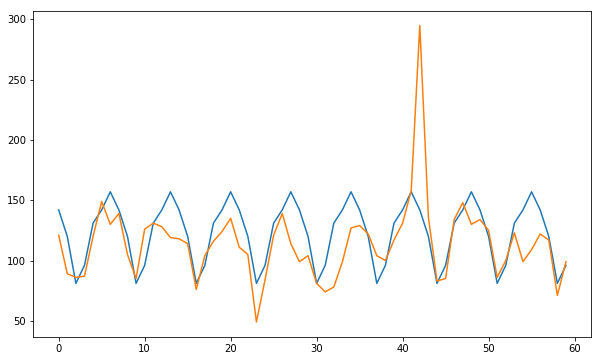

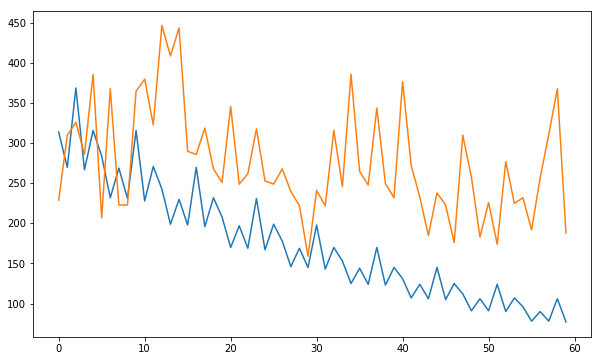

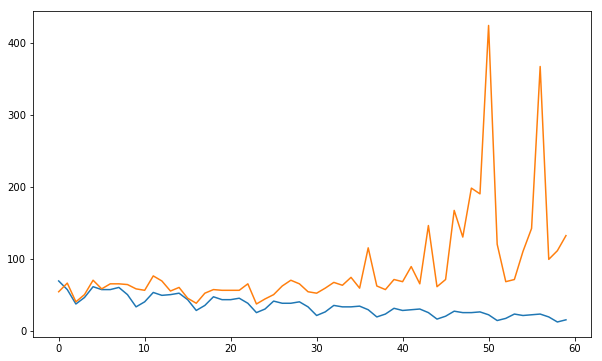

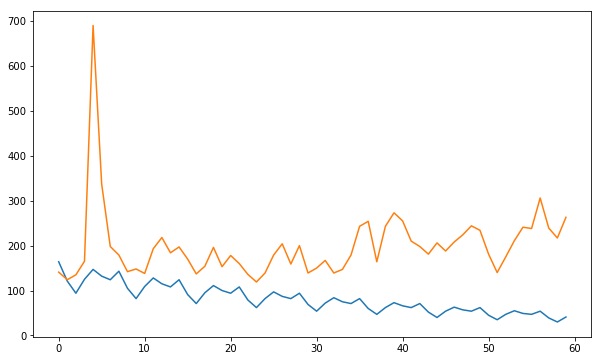

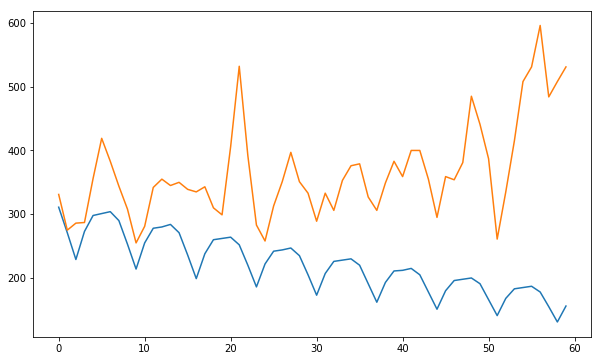

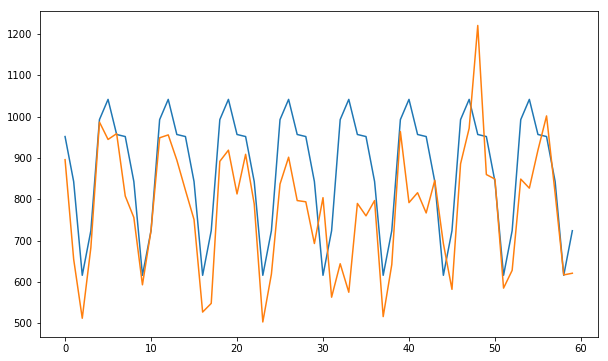

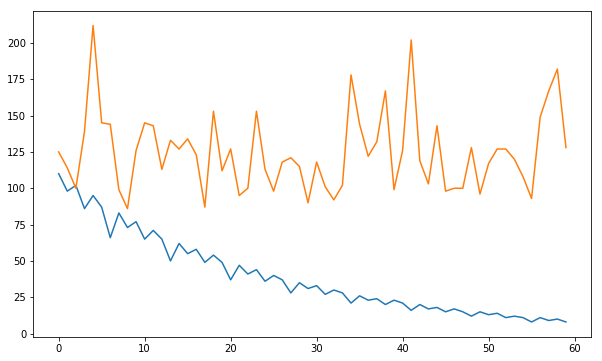

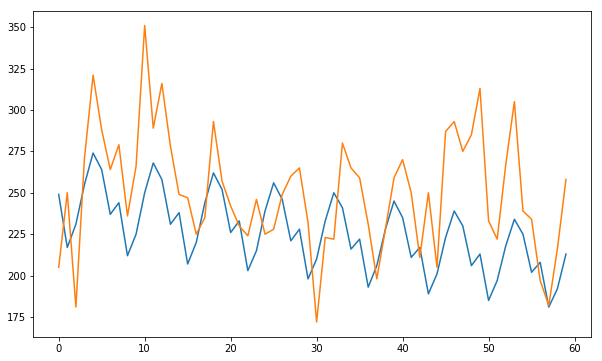

In [121]:
for i in range(10):
    plt.plot(predictions[true_weekly][i][0])
    plt.plot(test.values[true_weekly][i][0])
    plt.show()

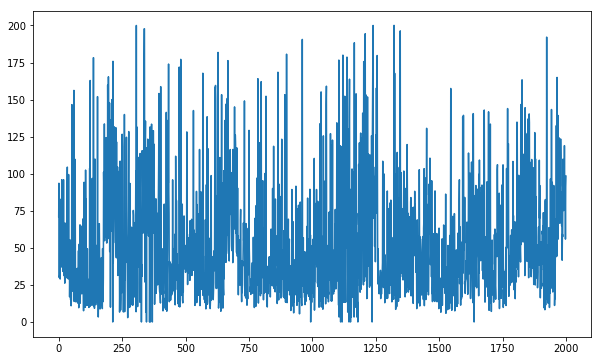

In [89]:
plt.plot(scores)